In [4]:
"""All required modules"""
!pip install torch-geometric
from numpy import loadtxt
import numpy as np
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch.optim import Adam
import numpy as np
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import joblib
import time
from torch.nn import BCEWithLogitsLoss
from sklearn.model_selection import train_test_split

In [5]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 42
set_seed(seed)

In [6]:
#installing drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
#loads target variables as 0-1
winners = pd.read_csv("/content/drive/MyDrive/My_stratego_project/files/Y_winners_encoded.csv", header = None)
#loads dataset with added encoded strategies
positions = joblib.load('/content/drive/MyDrive/My_stratego_project/files/X_encoded_strategies_and_positions.txt')


In [8]:
"""Changes the one hot encoding to a row hot encoding"""
#positions = joblib.load('/content/drive/MyDrive/My_stratego_project/files/X_rowencoded_strategies_and_positions.txt') #comment out if you want to use the one-hot encoding instead


'Changes the one hot encoding to a row hot encoding'

In [9]:
"""Changes the one hot encoding to a normalized row hot encoding"""
#positions = joblib.load('/content/drive/MyDrive/My_stratego_project/files/X_encoded_strategies_and_positions_normalized.txt') #comment out if you want to use the one-hot encoding instead


'Changes the one hot encoding to a normalized row hot encoding'

In [10]:
"""Uncomment to use the dataset which has no added encoded strategies"""
#positions = np.load('/content/drive/MyDrive/My_stratego_project/files/X_encoded_positions.txt')

#positions = np.array(positions).reshape(99130, 40, 12) #Reshaping the data to a 40 by 12 matrix



'Uncomment to use the dataset which has no added encoded strategies'

In [11]:
"""for -1 to 1 classification, changes winner variable to -1 and 1, comment out to use 0/1 classification"""
winners_new = []
i=0
for winner in winners[0]:
  if winner == 0:
    winners_new.append(winner-1)
  else:
    winners_new.append(winner)
  i+=1

In [12]:
"""Creates 4 edge indeces based on the sizes created after the sagpooling operation, they're all square boards"""

##Possible imporvement to be added is to create edge index based on removed and included nodes after the sagpooling operation
def edge_index(row,column):
  """Creates a edge index based on a number of rows and columns as input"""
  edge_index = []
  for row in range(num_rows):
      for col in range(num_cols):
          node_idx = row * num_cols + col

          if row > 0:  #connect to top neighbor
              top_neighbor_idx = (row - 1) * num_cols + col
              edge_index.append([node_idx, top_neighbor_idx])

          if row < num_rows - 1:  #connect to bottom neighbor
              bottom_neighbor_idx = (row + 1) * num_cols + col
              edge_index.append([node_idx, bottom_neighbor_idx])

          if col > 0:  #connect to left neighbor
              left_neighbor_idx = row * num_cols + (col - 1)
              edge_index.append([node_idx, left_neighbor_idx])

          if col < num_cols - 1:  #connect to right neighbor
              right_neighbor_idx = row * num_cols + (col + 1)
              edge_index.append([node_idx, right_neighbor_idx])

  return torch.tensor(edge_index).t().contiguous()

num_rows = 4
num_cols = 10
edge_index1 = edge_index(num_rows , num_cols)#(4,10)

num_rows = 3
num_cols = 10
edge_index2 = edge_index(num_rows , num_cols)#(3,10)

num_rows = 2
num_cols = 10
edge_index3 = edge_index(num_rows , num_cols)#(2,10)

num_rows = 2
num_cols = 5
edge_index4 = edge_index(num_rows , num_cols)#(2,5)


In [13]:
edge_index4.shape

torch.Size([2, 26])

In [14]:
def custom_collate(batch):
    if isinstance(batch[0], Data):
        #if the elements of the batch are Data objects,
        #return a list of Data objects
        return batch


In [15]:

#defines a train test split with 0.2 test data
train_dataset, test_dataset = train_test_split(positions, test_size=0.2, random_state=42)


In [17]:
matches_dataset = list()
i=-1
for game in train_dataset:#creates a dataloader object with batches of size 503 for training data
  i+=1
  matches_dataset.append(Data(x=torch.tensor(game), edge_index=edge_index1, y=torch.tensor(winners_new[i])))
matches_loader_12_features_training = DataLoader(matches_dataset, batch_size=751, collate_fn=custom_collate, shuffle=False)

matches_dataset = list()
i=-1
for game in test_dataset:#creates a dataloader object with batches of size 503 for training data
  i+=1
  matches_dataset.append(Data(x=torch.tensor(game), edge_index=edge_index1, y=torch.tensor(winners_new[i])))
matches_loader_12_features_test = DataLoader(matches_dataset, batch_size=751, collate_fn=custom_collate, shuffle=False)

In [18]:
matches_dataset = list()
i=-1
for game in train_dataset:#creates a dataloader object with batches of size 503, dummy features for training data
  i+=1
  matches_dataset.append(Data(x=torch.tensor(np.argmax(game, axis=1)).reshape(40,1), edge_index=edge_index1, y=torch.tensor(winners_new[i])))

matches_loader_1dummy_training = DataLoader(matches_dataset, batch_size=751, collate_fn=custom_collate, shuffle=False)


matches_dataset = list()
i=-1
for game in test_dataset:#creates a dataloader object with batches of size 503, dummy features for test data
  i+=1
  matches_dataset.append(Data(x=torch.tensor(np.argmax(game, axis=1)).reshape(40,1), edge_index=edge_index1, y=torch.tensor(winners_new[i])))

matches_loader_1dummy_test = DataLoader(matches_dataset, batch_size=751, collate_fn=custom_collate, shuffle=False)

In [19]:
len(matches_loader_12_features_training.dataset)

79304

In [20]:
len(matches_loader_12_features_test.dataset)

19826

In [21]:
from torch_geometric.nn import SAGPooling
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, GATv2Conv, TransformerConv, SAGEConv
from torch_geometric.nn import global_mean_pool


class SimpleRNN(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleRNN, self).__init__()
        self.linear1 = nn.Linear(input_dim, input_dim)
        self.linear2 = nn.Linear(input_dim, input_dim)
        self.linear3 = nn.Linear(input_dim, 1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        ##Layer 1##
        x = self.linear1(x)
        x = self.tanh(x)
        x = F.dropout(x, p=0.1, training=self.training)
        ##Layer 2##
        x = self.linear2(x)
        x = self.tanh(x)
        x = F.dropout(x, p=0.1, training=self.training)
        ##Final layer##
        x = self.linear3(x)
        x = self.tanh(x)
        #x = F.dropout(x, p=0.1, training=self.training)
        x = torch.sum(x)
        #x = self.tanh(x)


        return x

In [22]:

#define train and test set
matches_loader_12_features_training
matches_loader_12_features_test
#define record keeping
batch_loss = 0
epoch_losses =[]
batch_losses=[]
#2.Instantiate the Model
input_size = 17  # Assuming each node has 12 features

model = SimpleRNN(input_size,1)


#3.Define Loss Function and Optimizer
criterion = nn.MSELoss()
#criterion = nn.MarginRankingLoss(margin=1)
optimizer = Adam(model.parameters(), lr=0.001)


#4.Training Loop

num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    start_epoch_time = time.time() # Record start time of epoch

    for batch_idx, batch in enumerate(matches_loader_12_features_training):
        start_batch_time = time.time() # Record start time of batch
        data_idx = 0
        batch_output = torch.tensor([])
        batch_y = []
        total_batch_loss = 0

        for data in range(len(batch)):
            optimizer.zero_grad()

            x, y = batch[data_idx].x.float(), batch[data_idx].y
            output = model(x)
            if batch_output.numel() == 0:
                batch_output = output.unsqueeze(0)
            else:
                batch_output = torch.cat((batch_output, output.unsqueeze(0)), dim=0)
            batch_y.append(y)
            data_idx += 1
        loss = criterion(batch_output, torch.tensor(batch_y))
        loss.backward()
        optimizer.step()
        total_batch_loss += loss

        end_batch_time = time.time() # Record end time of batch

        # Calculate average loss for this batch
        avg_batch_loss = total_batch_loss
        batch_losses.append(avg_batch_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(matches_loader_12_features_training)}], "
              f"Time: {end_batch_time - start_batch_time:.4f} sec, Avg Batch Loss: {avg_batch_loss:.6f}")

    end_epoch_time = time.time() # Record end time of epoch
    avg_epoch_loss = sum(batch_losses) / len(batch_losses)
    epoch_losses.append(avg_epoch_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Avg Epoch Loss: {avg_epoch_loss:.6f}, "
          f"Epoch Time: {end_epoch_time - start_epoch_time:.4f} sec")


Epoch [1/3], Batch [1/106], Time: 0.9587 sec, Avg Batch Loss: 84.614761
Epoch [1/3], Batch [2/106], Time: 0.8289 sec, Avg Batch Loss: 66.990417
Epoch [1/3], Batch [3/106], Time: 1.0970 sec, Avg Batch Loss: 54.132755
Epoch [1/3], Batch [4/106], Time: 1.1357 sec, Avg Batch Loss: 43.708866
Epoch [1/3], Batch [5/106], Time: 1.1803 sec, Avg Batch Loss: 30.956730
Epoch [1/3], Batch [6/106], Time: 1.0924 sec, Avg Batch Loss: 24.380783
Epoch [1/3], Batch [7/106], Time: 0.7889 sec, Avg Batch Loss: 20.721975
Epoch [1/3], Batch [8/106], Time: 0.7785 sec, Avg Batch Loss: 18.270252
Epoch [1/3], Batch [9/106], Time: 0.8120 sec, Avg Batch Loss: 17.086414
Epoch [1/3], Batch [10/106], Time: 0.7804 sec, Avg Batch Loss: 14.596629
Epoch [1/3], Batch [11/106], Time: 0.7690 sec, Avg Batch Loss: 13.047831
Epoch [1/3], Batch [12/106], Time: 0.7857 sec, Avg Batch Loss: 13.729600
Epoch [1/3], Batch [13/106], Time: 0.7776 sec, Avg Batch Loss: 15.024385
Epoch [1/3], Batch [14/106], Time: 0.7817 sec, Avg Batch Los

In [23]:
batch_output, batch.y

(tensor([ 0.1182,  0.2102, -0.6312, -0.0346, -0.2033,  0.5909, -0.3327,  0.2709,
         -0.3180,  0.1545,  0.3764, -0.7203,  0.5690, -0.4577, -0.3560,  0.7322,
         -0.6871, -0.5939,  0.7652,  0.3792, -0.6033,  0.1391, -0.3783,  0.4454,
         -0.2104,  0.0449,  1.0361, -0.3518,  0.3668, -0.3141, -0.4537,  0.2404,
         -1.2885,  0.1770, -0.6444,  0.1166,  0.3604,  0.5903, -0.3496,  0.0868,
          0.7235, -0.6581, -0.0809, -0.0655, -1.0585,  0.2685, -0.2161, -0.3324,
          0.2968,  0.7311,  0.9694, -0.3256, -0.0067, -0.5500,  0.2438,  0.2064,
          0.4271,  1.4919,  0.1899, -0.1277,  0.6075,  0.5992, -0.5702,  0.0318,
         -0.4634, -0.0907,  0.0657,  0.0603,  0.7081, -0.4607, -0.1890,  0.1383,
          0.6595, -0.2731, -0.0792, -0.9080,  0.0131,  0.0714, -0.9614,  0.3324,
          0.5379,  0.4490,  0.5472,  0.4222, -0.1004, -0.6550,  1.0862,  0.7210,
         -0.2655,  0.6682, -0.4237, -0.0328, -0.6073, -0.0410,  0.0032,  0.9975,
         -0.7578, -0.0610, -

In [24]:
epoch_losses

[tensor(6.5203, grad_fn=<DivBackward0>),
 tensor(3.9772, grad_fn=<DivBackward0>),
 tensor(3.0931, grad_fn=<DivBackward0>)]

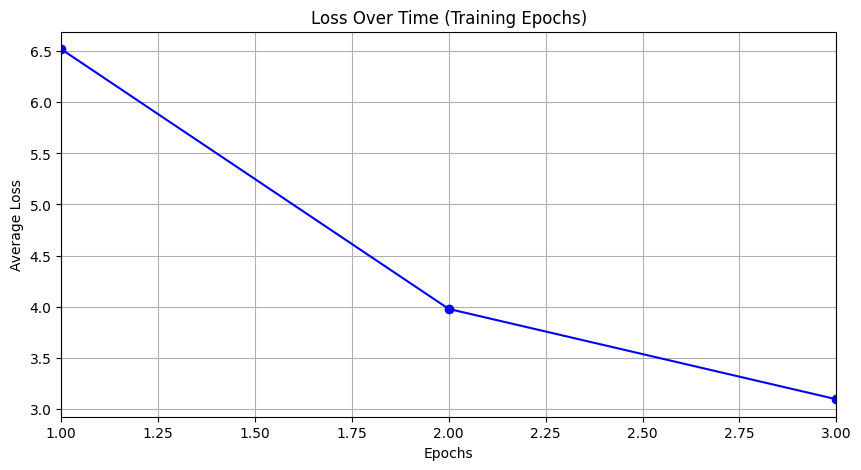

In [25]:
import matplotlib.pyplot as plt


#remove gradients from tensor list
ep_loss_list = []
for loss in epoch_losses:
  ep_loss_list.append(loss.detach().numpy())

# Loss Over Time (Training Epochs)
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), ep_loss_list, marker='o', color='b')
plt.title('Loss Over Time (Training Epochs)')
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.grid(True)
plt.xlim(1, num_epochs)  # Set x limits
#plt.ylim(0, 100)  # Set y limits
plt.show()


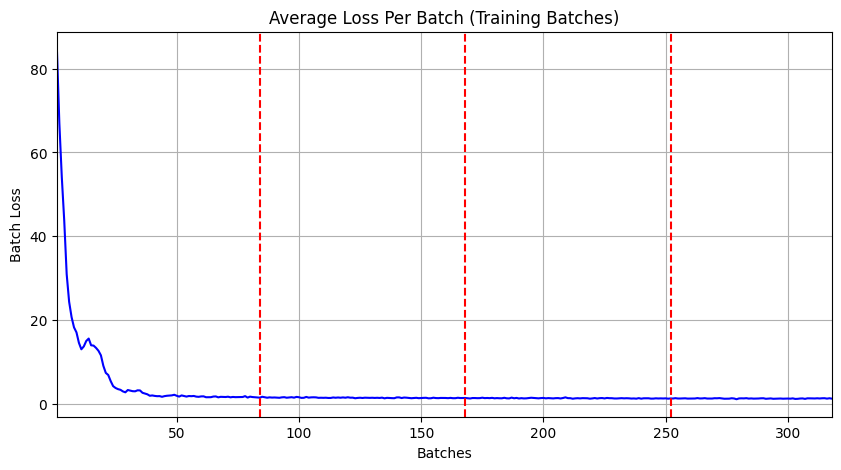

In [26]:
#remove gradients from tensor list
batch_loss_list = []
for loss in batch_losses:
  batch_loss_list.append(loss.detach().numpy())



# Loss Per Batch (Training Batches)
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(batch_loss_list)+1), batch_loss_list, color='b')
plt.title('Average Loss Per Batch (Training Batches)')
plt.xlabel('Batches')
plt.ylabel('Batch Loss')
plt.grid(True)
plt.xlim(1, len(batch_loss_list))  # Set x limits
#plt.ylim(0, 100)  # Set y limits

for batch_idx in range(1, len(batch_loss_list)+1):
    if batch_idx % 84 == 0:
        plt.axvline(x=batch_idx, color='r', linestyle='--')

plt.show()


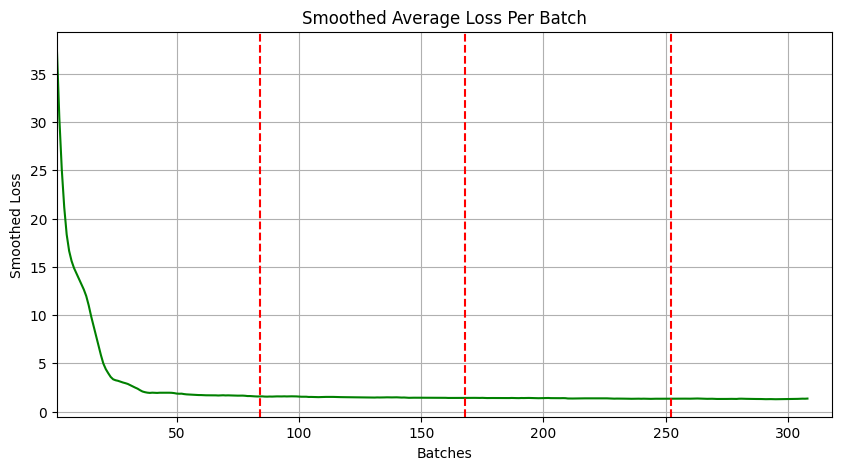

In [27]:
# Smoothed Loss Per Batch
smoothed_losses = [sum(batch_loss_list[i:i+10])/10 for i in range(len(batch_loss_list)-10)]
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(smoothed_losses)+1), smoothed_losses, color='g')
plt.title('Smoothed Average Loss Per Batch')
plt.xlabel('Batches')
plt.ylabel('Smoothed Loss')
plt.grid(True)
plt.xlim(1, len(batch_loss_list))  # Set x limits
#plt.ylim(0, 100)  # Set y limits
for batch_idx in range(1, len(batch_loss_list)+1):
    if batch_idx % 84 == 0:
        plt.axvline(x=batch_idx, color='r', linestyle='--')

plt.show()

In [28]:
# 5. Evaluation
"""MSE calculation"""
#set to model eval mode
model.eval()

#record keeping
correct = 0
total_loss = 0
total = 0
total_batches = len(matches_loader_12_features_test)
average_MSE = 0
average_MSE_list = []
total_MSE_avg = []
total_MSE = 0


start_time = time.time()  #record start time

with torch.no_grad():
    for batch_idx, batch in enumerate(matches_loader_12_features_test):
        iteration = 0  # index for element in batch
        batch_correct = 0
        batch_total = 0
        batch_error = 0
        for data in range(len(batch)):
            x, y = batch[iteration].x.float(), batch[iteration].y.float()  # Extract node features, edge index, and target labels

            output = model(x)
            total_loss += criterion(output, y).item()
            error = (y-output)**2
            batch_error += error
            batch_total += 1
            total += 1
        total_MSE += batch_error
        avg_batch_MSE = batch_error / batch_total
        average_MSE_list.append(avg_batch_MSE)

        print(f'Batch {batch_idx + 1}/{total_batches}, MSE: {avg_batch_MSE.item():.2f}')

# Compute overall MSE
MSE_avg = sum(average_MSE_list) / 21 #21 is number of batches in test set
end_time = time.time()  # Record end time
total_time = end_time - start_time
print(f'Total Time taken: {total_time:.2f} seconds')
print(f'Validation MSE: {float(total_MSE):.2f}')
print(f'Average MSE per Batch: {MSE_avg.float().item():.2f}')



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Batch 1/27, MSE: 0.64
Batch 2/27, MSE: 1.69
Batch 3/27, MSE: 0.54
Batch 4/27, MSE: 0.66
Batch 5/27, MSE: 1.56
Batch 6/27, MSE: 1.65
Batch 7/27, MSE: 1.24
Batch 8/27, MSE: 0.70
Batch 9/27, MSE: 0.48
Batch 10/27, MSE: 1.12
Batch 11/27, MSE: 0.93
Batch 12/27, MSE: 0.78
Batch 13/27, MSE: 1.32
Batch 14/27, MSE: 1.32
Batch 15/27, MSE: 1.52
Batch 16/27, MSE: 1.59
Batch 17/27, MSE: 0.84
Batch 18/27, MSE: 0.81
Batch 19/27, MSE: 1.21
Batch 20/27, MSE: 4.23
Batch 21/27, MSE: 1.40
Batch 22/27, MSE: 1.71
Batch 23/27, MSE: 0.27
Batch 24/27, MSE: 1.74
Batch 25/27, MSE: 0.45
Batch 26/27, MSE: 1.57
Batch 27/27, MSE: 0.09
Total Time taken: 16.17 seconds
Validation MSE: 24046.24
Average MSE per Batch: 1.53


In [29]:
# 5. Evaluation set to accuracy calculation instead of MSE
"""Accuracy calculation"""
#set to model eval mode
model.eval()

#record keeping
correct = 0
total_loss = 0
total = 0
total_batches = len(matches_loader_12_features_test)
average_MSE = 0
batch_accuracy_list = []
total_MSE_avg = []
total_correct = 0
accuracy = 0

start_time = time.time()  #record start time

with torch.no_grad():
    for batch_idx, batch in enumerate(matches_loader_12_features_test):
        iteration = -1  # index for element in batch
        batch_total = 0
        batch_accuracy = 0
        correct = 0
        for data in range(len(batch)):
            iteration+=1
            x, y = batch[iteration].x.float(), batch[iteration].y.float()  # Extract node features, edge index, and target labels

            output = model(x)
            total_loss += criterion(output, y).item()


            if (output.float()>=0) and y==1:
              correct += 1
            elif (output.float()<=0) and y==-1:
              correct += 1
            else:
              correct += 0


            batch_total += 1
            total += 1
        batch_accuracy = correct / batch_total
        batch_accuracy_list.append(batch_accuracy)
        total_correct += correct
        print(f'Batch {batch_idx + 1}/{total_batches}, Accuracy: {batch_accuracy:.2f}')

# Compute overall accuracy
accuracy_avg = total_correct / len(matches_loader_12_features_test.dataset) #21 is number of batches in test set
end_time = time.time()  # Record end time
total_time = end_time - start_time
print(f'Total Time taken: {total_time:.2f} seconds')
print(f'Validation correct predictions: {float(total_correct):.2f}')
print(f'Average accuracy per batch: {accuracy_avg:.4f}')



Batch 1/27, Accuracy: 0.50
Batch 2/27, Accuracy: 0.49
Batch 3/27, Accuracy: 0.50
Batch 4/27, Accuracy: 0.50
Batch 5/27, Accuracy: 0.50
Batch 6/27, Accuracy: 0.52
Batch 7/27, Accuracy: 0.51
Batch 8/27, Accuracy: 0.49
Batch 9/27, Accuracy: 0.51
Batch 10/27, Accuracy: 0.51
Batch 11/27, Accuracy: 0.52
Batch 12/27, Accuracy: 0.45
Batch 13/27, Accuracy: 0.52
Batch 14/27, Accuracy: 0.49
Batch 15/27, Accuracy: 0.49
Batch 16/27, Accuracy: 0.50
Batch 17/27, Accuracy: 0.48
Batch 18/27, Accuracy: 0.53
Batch 19/27, Accuracy: 0.49
Batch 20/27, Accuracy: 0.52
Batch 21/27, Accuracy: 0.52
Batch 22/27, Accuracy: 0.50
Batch 23/27, Accuracy: 0.49
Batch 24/27, Accuracy: 0.50
Batch 25/27, Accuracy: 0.52
Batch 26/27, Accuracy: 0.50
Batch 27/27, Accuracy: 0.46
Total Time taken: 14.10 seconds
Validation correct predictions: 9925.00
Average accuracy per batch: 0.5006


Save RNN model

In [30]:
""""Please download this file and upload it to the files folder in the project"""
""""You need this file to run the 'testing of different positions' notebook"""
torch.save(model.state_dict(), 'RNNmodelCPU.pth') #saves model parameters

In [31]:
#2nd phase include creation of own data with minor changes and check how the model responds to it
#This is done in Position_effects_on_model_predictions.ipynb